In [1]:
import sys
sys.path.append('../src/SARRA_data_download/')
from get_satellite_rainfall_estimates import *

# Run params

In [2]:
# coordinates of area : lat NW, lon NW, lat SE, lon SE
area = {
    'burkina': [16, -6, 9, 3],
    'niger':[23.8, -0.5, 11.3, 15.9],
    'west_africa':[29, -20, 3.5, 26]}

selected_area = "burkina"

save_path = "../data/3_output/"

year = 2020

# Run downloads

In [3]:
download_TAMSAT_year(year, area, selected_area, save_path)
# download_CHIRPS_year(year, area, selected_area, save_path)

100%|██████████| 366/366 [04:18<00:00,  1.42it/s]


In [3]:
# getting grid dims from TAMSAT data (most finely resolved)
rainfall_path = "../data/3_output/TAMSAT_v3.1_burkina_rfe_filled/"
date_start = datetime.date(2020,1,1)
duration = 365
# grid_width, grid_height = get_grid_size(rainfall_path, date_start, duration)

In [4]:
grid_width, grid_height

(186, 239)

In [5]:
def load_TAMSAT_data(data, TAMSAT_path, date_start, duration):
    """
    This function loops over the rainfall raster files, and loads them into a
    xarray DataArray, which is then added to the rain data dictionary. It is
    tailored to the TAMSAT rainfall data files, hence its name.

    Args:
        data (_type_): _description_
        TAMSAT_path (_type_): _description_
        date_start (_type_): _description_
        duration (_type_): _description_

    Returns:
        _type_: _description_
    """

    TAMSAT_files_df = build_rainfall_files_df(TAMSAT_path, date_start, duration)

    for i in range(len(TAMSAT_files_df)):

        dataarray = rioxarray.open_rasterio(os.path.join(TAMSAT_path,TAMSAT_files_df.loc[i,"filename"]))
        dataarray = dataarray.squeeze("band").drop_vars(["band", "spatial_ref"])
        dataarray.attrs = {}

        try:
            dataarray_full = xr.concat([dataarray_full, dataarray],"time")
        except:
            dataarray_full = dataarray

    dataarray_full.rio.write_crs(4326,inplace=True)
    data["rain"] = dataarray_full
    data["rain"].attrs = {"units":"mm", "long_name":"rainfall"}

    return data

In [7]:
data = xr.Dataset()
load_TAMSAT_data(data, rainfall_path, date_start, duration)

<xarray.Dataset>
Dimensions:      (x: 239, y: 186, time: 365)
Coordinates:
  * x            (x) float64 -5.963 -5.925 -5.888 -5.85 ... 2.887 2.925 2.962
  * y            (y) float64 15.97 15.94 15.9 15.86 ... 9.15 9.113 9.075 9.038
    spatial_ref  int64 0
Dimensions without coordinates: time
Data variables:
    rain         (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [13]:
import numpy as np

def load_lower_res_rain_data(data, rainfall_path, date_start, duration, new_var_name):
    """
    This function loops over the rainfall raster files, and loads them into a
    xarray DataArray, which is then added to the rain data dictionary. It is
    tailored to the TAMSAT rainfall data files, hence its name.

    Args:
        data (_type_): _description_
        TAMSAT_path (_type_): _description_
        date_start (_type_): _description_
        duration (_type_): _description_

    Returns:
        _type_: _description_
    """

    rainfall_files_df = build_rainfall_files_df(rainfall_path, date_start, duration)

    for i in range(len(rainfall_files_df)):

        dataarray = rioxarray.open_rasterio(os.path.join(rainfall_path,rainfall_files_df.loc[i,"filename"]))
        dataarray = dataarray.rio.reproject_match(data, nodata=np.nan)

        
        dataarray = dataarray.squeeze("band").drop_vars(["band", "spatial_ref"])
        dataarray.attrs = {}

        try:
            dataarray_full = xr.concat([dataarray_full, dataarray],"time")
        except:
            dataarray_full = dataarray

    dataarray_full.rio.write_crs(4326,inplace=True)
    data[new_var_name] = dataarray_full
    data[new_var_name].attrs = {"units":"mm", "long_name":"rainfall"}

    return data

In [14]:
rainfall_path = "../data/3_output/CHIRPS_v2.0_Africa_burkina"
new_var_name = "rain_CHIRPS"
data = load_lower_res_rain_data(data, rainfall_path, date_start, duration, new_var_name)

In [15]:
data

<xarray.Dataset>
Dimensions:      (x: 239, y: 186, time: 365)
Coordinates:
  * x            (x) float64 -5.963 -5.925 -5.888 -5.85 ... 2.887 2.925 2.962
  * y            (y) float64 15.97 15.94 15.9 15.86 ... 9.15 9.113 9.075 9.038
    spatial_ref  int64 0
Dimensions without coordinates: time
Data variables:
    rain         (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rain_CHIRPS  (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

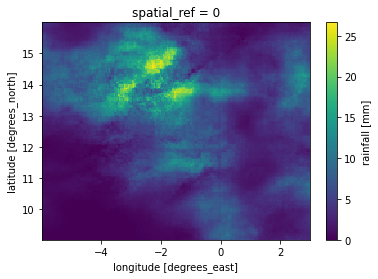

In [30]:
data["rain_CHIRPS"][200,:,:].plot()

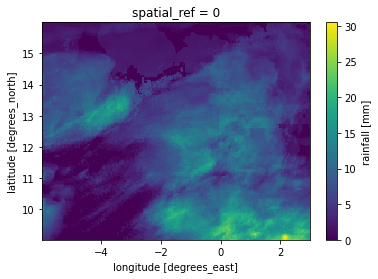

In [29]:
data["rain"][200,:,:].plot()

In [40]:
data["rain_mean"] = (data["rain"] + data["rain_CHIRPS"])/2

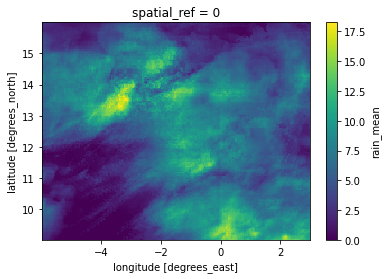

In [41]:
data["rain_mean"][200,:,:].plot()

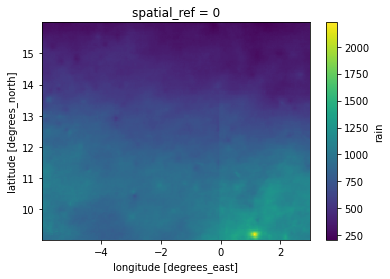

In [42]:
data["rain"].sum(dim="time").plot()

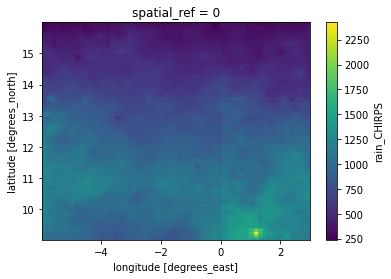

In [43]:
data["rain_CHIRPS"].sum(dim="time").plot()

In [45]:
data["rain_delta"] = (data["rain"] - data["rain_CHIRPS"])

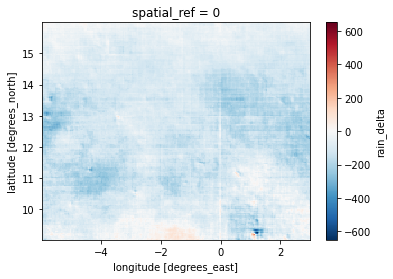

In [47]:
data["rain_delta"].sum(axis=0).plot()

# IMERG

In [5]:
def download_IMERG_day(query_date, save_path):

    query_month = query_date.strftime('%m')
    query_day = query_date.strftime('%d')
    doy = query_date.timetuple().tm_yday


    URL_filename = ("3B-DAY-GIS.MS.MRG.3IMERG."+str(query_date.year)+query_month+query_day+"-S000000-E235959."+f"{30*(doy-1):04d}"+".V06B.tif")
    URL_full = "https://arthurhouhttps.pps.eosdis.nasa.gov/gpmdata/"+str(query_date.year)+"/"+query_month+"/"+query_day+"/gis/"+URL_filename

    # print(URL_full)

    response = requests.get(URL_full, auth=('jeremy.lavarenne@cirad.fr', 'jeremy.lavarenne@cirad.fr'))
    save_filename = "IMERG_"+URL_filename.replace("/","_")
    open(os.path.join(save_path,save_filename), "wb").write(response.content)

In [6]:
def crop_and_save_IMERG_day(query_date, area, selected_area, save_path):

    query_month = query_date.strftime('%m')
    query_day = query_date.strftime('%d')
    doy = query_date.timetuple().tm_yday
    URL_filename = ("3B-DAY-GIS.MS.MRG.3IMERG."+str(query_date.year)+query_month+query_day+"-S000000-E235959."+f"{30*(doy-1):04d}"+".V06B.tif")
    save_filename = "IMERG_"+URL_filename.replace("/","_")
    nc_file_content = xr.open_dataset(os.path.join(save_path,save_filename))

    xarray_variable_name = "band_data"

    # cropping
    nc_file_content = nc_file_content.where((nc_file_content.y < area[selected_area][0])
                            & (nc_file_content.y > area[selected_area][2])
                            & (nc_file_content.x > area[selected_area][1])
                            & (nc_file_content.x < area[selected_area][3])
                        ).dropna(dim='y', how='all').dropna(dim='x', how='all')

    bT = nc_file_content[xarray_variable_name]
    bT = bT.rio.set_spatial_dims(x_dim='x', y_dim='y')
    bT.rename(new_name_or_name_dict={"x":"lon", "y":"lat"})
    bT.rio.crs
    bT.rio.write_crs("epsg:4326", inplace=True)
    output_filename = "IMERG_"+selected_area+"_"+xarray_variable_name+"_"+str(query_date.year)+"_"+str(query_month)+"_"+str(query_day)+".tif"
    output_path = "../data/3_output/IMERG_"+selected_area+"_"+xarray_variable_name+"/"

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    bT.rio.to_raster(os.path.join(output_path,output_filename))

In [7]:
def download_IMERG_year(query_year, area, selected_area, save_path):

    end_date = datetime.date(query_year,12,31)
    start_date = datetime.date(query_year,1,1)
    num_days = (end_date-start_date).days
    
    for num_day in tqdm(range(num_days+1)) :

        query_date_loop = datetime.date(query_year,1,1) + datetime.timedelta(days=num_day)

        #print("=== downloading TAMSAT for date",query_date_loop,"===")
        try:
            download_IMERG_day(query_date_loop, save_path)
            crop_and_save_IMERG_day(query_date_loop, area, selected_area, save_path)
        except:
            print("nope")

In [8]:
save_path = "../data/3_output/IMERG/"
download_IMERG_year(2020, area, selected_area, save_path)

 67%|██████▋   | 247/366 [05:52<02:50,  1.43s/it]